In [58]:
# ==========================
# Standard Library Imports
# ==========================
import os
import re
import string
import warnings
from collections import Counter

# ==========================
# Data Handling
# ==========================
import pandas as pd
import numpy as np

# ==========================
# NLP & Text Processing
# ==========================
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import spacy
nlp = spacy.load("en_core_web_sm")  # For Named Entity Recognition (NER)

from textblob import TextBlob  # For sentiment analysis

# ==========================
# Feature Extraction & Vectorization
# ==========================
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ==========================
# Machine Learning (Clustering, Topic Modeling, Dimensionality Reduction)
# ==========================
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE

# ==========================
# Association Rule Mining
# ==========================
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.patches import Patch

# ==========================
# Warnings
# ==========================
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
def clean_text(text):
    """
    Clean raw email text for NLP processing.
    Steps:
      1. Lowercase
      2. Remove URLs and emails
      3. Remove punctuation and digits
      4. Remove extra whitespace
    """
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs and emails
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', ' ', text)

    # 3. Remove punctuation and digits
    text = re.sub(f"[{re.escape(string.punctuation)}0-9]", " ", text)

    # 4. Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text


###Download, unzip, and move the folder ***Archive*** from this [dataset](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset/data?select=CEAS_08.csv) to your google drive. Then proceed to mount google drive in the next code block.

In [5]:
from google.colab import drive
import os
import pandas as pd

# --- Mount Google Drive ---
drive.mount('/content/drive')

# --- Dataset Directory ---
dataset_dir = "/content/drive/MyDrive/archive"

# --- Collect texts and labels ---
texts, labels = [], []

# Iterate through CSV files (skip phishing_email.csv because its label is different)
for filename in os.listdir(dataset_dir):
    if filename.endswith('.csv') and filename != 'phishing_email.csv':
        print(f"Loading: {filename}")
        df = pd.read_csv(os.path.join(dataset_dir, filename)).dropna(subset=['body', 'label'])
        texts.extend(df['body'].tolist())
        labels.extend(df['label'].tolist())

# --- Create DataFrame ---
df_emails = pd.DataFrame({'body': texts, 'label': labels})

# --- Clean the email texts ---
df_emails['clean_body'] = df_emails['body'].apply(clean_text)

# --- Basic EDA ---
# 1. Class distribution
print("Class distribution:")
print(df_emails['label'].value_counts())

# 2. Email length statistics
df_emails['word_count'] = df_emails['clean_body'].apply(lambda x: len(x.split()))
df_emails['char_count'] = df_emails['clean_body'].apply(len)

print("\nEmail length statistics by class:")
print(df_emails.groupby('label')[['word_count', 'char_count']].describe())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading: Ling.csv
Loading: CEAS_08.csv
Loading: Nigerian_Fraud.csv
Loading: Nazario.csv
Loading: Enron.csv
Loading: SpamAssasin.csv
Class distribution:
label
1    42890
0    39595
Name: count, dtype: int64

Email length statistics by class:
      word_count                                                              \
           count        mean          std  min   25%    50%    75%       max   
label                                                                          
0        39595.0  294.946635   724.416255  0.0  72.0  152.0  302.0   35004.0   
1        42890.0  181.768011  3181.729448  0.0  31.0   68.0  217.0  654202.0   

      char_count                                                        \
           count         mean           std  min    25%    50%     75%   
label                                                                    
0      

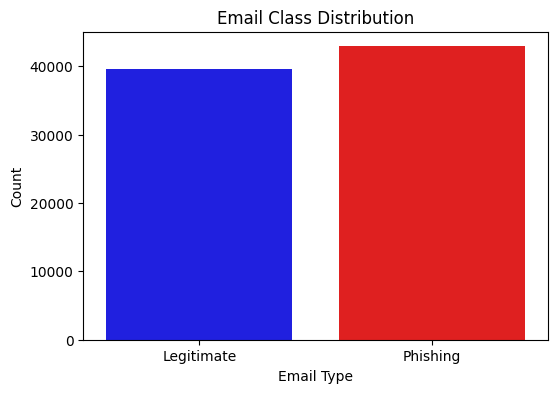

In [22]:
# Map numeric labels to descriptive names
df_emails['label_name'] = df_emails['label'].map({0: "Legitimate", 1: "Phishing"})

# --- Plot class distribution with descriptive labels ---
plt.figure(figsize=(6,4))
sns.countplot(x='label_name', hue='label_name', data=df_emails, palette=['blue', 'red'], legend=False)

plt.title("Email Class Distribution")
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.show()


###Each bar represents the number of emails in each class and the dataset is fairly balanced

In [16]:
# --- Get top words for phishing and legitimate emails ---

stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20):
    words = [w for text in texts for w in text.split() if w not in stop_words]
    return Counter(words).most_common(n)

# --- Separate phishing and legitimate emails ---
phishing_texts = df_emails[df_emails['label'] == 1]['clean_body']
legit_texts = df_emails[df_emails['label'] == 0]['clean_body']

# Create DataFrames of the most frequent words in phishing and legit emails
top_phishing_words = pd.DataFrame(get_top_words(phishing_texts), columns=['Word', 'Count'])
top_legit_words = pd.DataFrame(get_top_words(legit_texts), columns=['Word', 'Count'])

# --- Display top phishing words ---
print("Top Phishing Words:")
display(top_phishing_words.head(10))

# --- Display top legitimate words ---
print("Top Legitimate Words:")
display(top_legit_words.head(10))


Top Phishing Words:


,Word,Count
0,com,27218
1,e,26270
2,email,22638
3,cnn,21488
4,b,18862
5,c,18671
6,company,18568
7,please,18144
8,money,17657
9,top,17084


Top Legitimate Words:


,Word,Count
0,submission,53232
1,enron,52861
2,id,39972
3,ect,34716
4,would,25412
5,new,24215
6,e,22272
7,please,22009
8,com,21829
9,one,21240


###After removing common stopwords, this table shows the top 10 words used in phishing emails and legitimate emails in our dataset. Words that appear frequently here should lead to insights about phishing & legitimate emails. However, this is not the case because phishing language often overlaps with language used in legitimate emails.

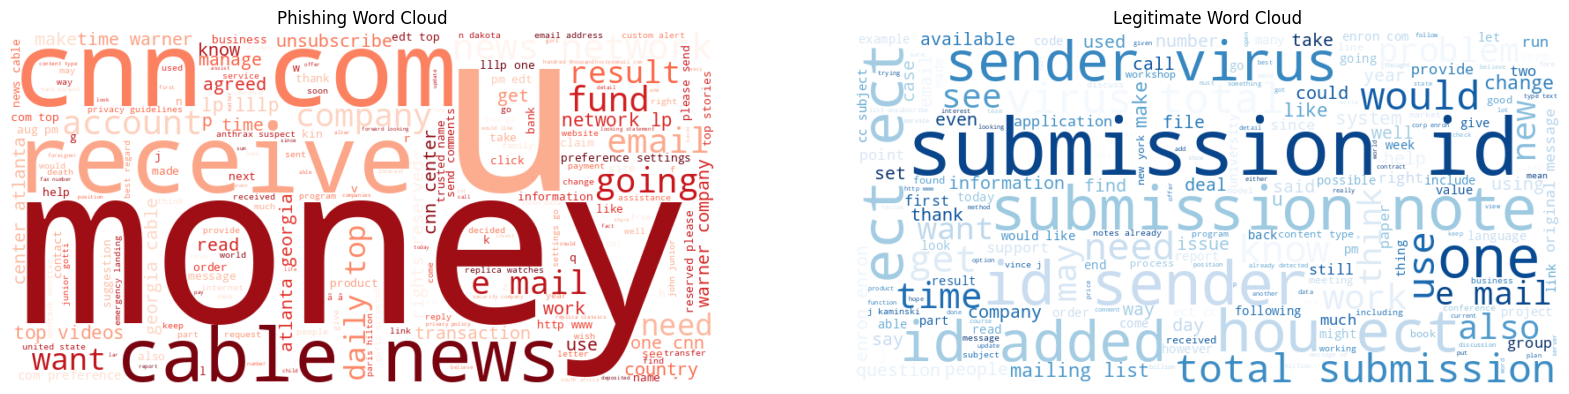

In [26]:
# --- Generate word clouds for phishing and legitimate emails ---

# Phishing word cloud
phishing_wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words,
    colormap='Reds'            # Red color map for phishing
).generate(" ".join(phishing_texts))

# Plot phishing word cloud
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(phishing_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Phishing Word Cloud")

# Legitimate word cloud
legit_wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words,
    colormap='Blues'           # Blue color map for legitimate emails
).generate(" ".join(legit_texts))

# Plot legitimate word cloud
plt.subplot(1,2,2)
plt.imshow(legit_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Legitimate Word Cloud")

plt.show()


###Because singular word analysis did not amount to much, we take a look at n-grams to try and capture phrases that are more indicative of phishing.

In [29]:
# --- Get top n-grams for phishing and legitimate emails ---

def get_top_ngrams(texts, ngram_range=(1,1), n=20, stop_words=None):
    # Convert stop_words to list if it's a set (CountVectorizer requires list or 'english' or None)
    if isinstance(stop_words, set):
        stop_words = list(stop_words)

    # Initialize vectorizer
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words)

    # Fit and transform texts
    X = vectorizer.fit_transform(texts)

    # Sum occurrences of each n-gram
    counts = X.sum(axis=0).A1
    ngrams = vectorizer.get_feature_names_out()

    # Pair n-grams with counts
    ngram_counts = list(zip(ngrams, counts))

    # Return top n
    return sorted(ngram_counts, key=lambda x: x[1], reverse=True)[:n]


In [33]:
# --- Comparing top n-grams for phishing emails ---
top_n = 20  # Number of n-grams per category

# Unigrams
top_unigrams = [ngram for ngram, _ in get_top_ngrams(phishing_texts, ngram_range=(1,1), n=top_n, stop_words=stop_words)]

# Bigrams
top_bigrams = [ngram for ngram, _ in get_top_ngrams(phishing_texts, ngram_range=(2,2), n=top_n, stop_words=stop_words)]

# Trigrams
top_trigrams = [ngram for ngram, _ in get_top_ngrams(phishing_texts, ngram_range=(3,3), n=top_n, stop_words=stop_words)]

# Combine into a DataFrame
import pandas as pd

ngrams_table = pd.DataFrame({
    "Unigram": pd.Series(top_unigrams),
    "Bigram": pd.Series(top_bigrams),
    "Trigram": pd.Series(top_trigrams)
})

# Display the table
display(ngrams_table)


,Unigram,Bigram,Trigram
0,com,cnn com,cable news network
1,email,cable news,network lp lllp
2,cnn,news network,news network lp
3,company,daily top,company rights reserved
4,please,lp lllp,atlanta georgia cable
5,money,network lp,center atlanta georgia
6,top,top videos,cnn center atlanta
7,us,rights reserved,cnn com preference
8,account,receive email,cnn com result
9,news,company rights,com preference settings


In [34]:
# --- Comparing top n-grams for legitimate emails ---
top_n = 20  # Number of n-grams per category

# Unigrams
top_unigrams_legit = [ngram for ngram, _ in get_top_ngrams(legit_texts, ngram_range=(1,1), n=top_n, stop_words=stop_words)]

# Bigrams
top_bigrams_legit = [ngram for ngram, _ in get_top_ngrams(legit_texts, ngram_range=(2,2), n=top_n, stop_words=stop_words)]

# Trigrams
top_trigrams_legit = [ngram for ngram, _ in get_top_ngrams(legit_texts, ngram_range=(3,3), n=top_n, stop_words=stop_words)]

# Combine into a DataFrame
ngrams_table_legit = pd.DataFrame({
    "Unigram": pd.Series(top_unigrams_legit),
    "Bigram": pd.Series(top_bigrams_legit),
    "Trigram": pd.Series(top_trigrams_legit)
})

# Display the table
display(ngrams_table_legit)


,Unigram,Bigram,Trigram
0,submission,submission id,submission id sender
1,enron,id sender,added submission id
2,id,submission notes,notes submission id
3,ect,hou ect,submission id added
4,would,added submission,submission notes submission
5,new,ect ect,id added submission
6,please,id added,id sender virus
7,com,notes submission,sender virus total
8,one,sender virus,total submission notes
9,message,virus total,virus total submission


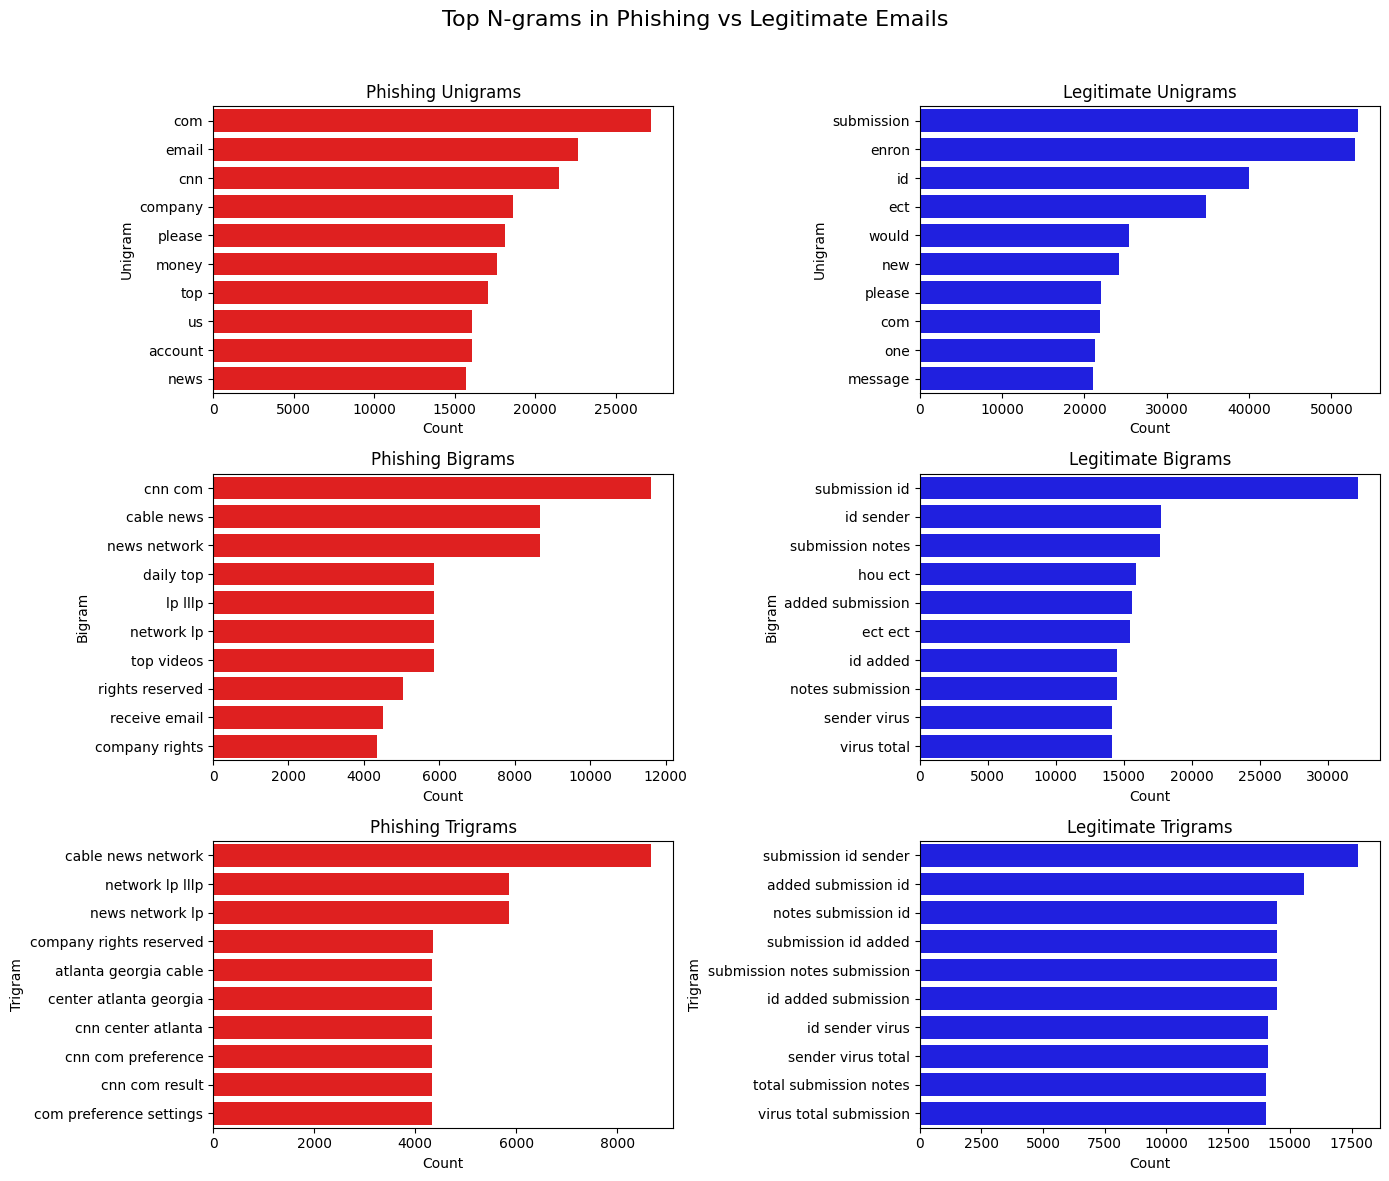

In [37]:
# --- Number of top n-grams to display ---
top_n = 10

# --- Prepare DataFrames for plotting (phishing) ---
top_phishing_unigrams_df = pd.DataFrame(get_top_ngrams(phishing_texts, ngram_range=(1,1), n=top_n, stop_words=stop_words), columns=['Unigram', 'Count'])
top_phishing_bigrams_df = pd.DataFrame(get_top_ngrams(phishing_texts, ngram_range=(2,2), n=top_n, stop_words=stop_words), columns=['Bigram', 'Count'])
top_phishing_trigrams_df = pd.DataFrame(get_top_ngrams(phishing_texts, ngram_range=(3,3), n=top_n, stop_words=stop_words), columns=['Trigram', 'Count'])

# --- Prepare DataFrames for plotting (legitimate) ---
top_legit_unigrams_df = pd.DataFrame(get_top_ngrams(legit_texts, ngram_range=(1,1), n=top_n, stop_words=stop_words), columns=['Unigram', 'Count'])
top_legit_bigrams_df = pd.DataFrame(get_top_ngrams(legit_texts, ngram_range=(2,2), n=top_n, stop_words=stop_words), columns=['Bigram', 'Count'])
top_legit_trigrams_df = pd.DataFrame(get_top_ngrams(legit_texts, ngram_range=(3,3), n=top_n, stop_words=stop_words), columns=['Trigram', 'Count'])

# --- Create figure with 2 columns and 3 rows ---
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Top N-grams in Phishing vs Legitimate Emails", fontsize=16)

# --- Row 1: Unigrams ---
sns.barplot(x='Count', y='Unigram', data=top_phishing_unigrams_df, color='red', ax=axes[0,0])
axes[0,0].set_title("Phishing Unigrams")
sns.barplot(x='Count', y='Unigram', data=top_legit_unigrams_df, color='blue', ax=axes[0,1])
axes[0,1].set_title("Legitimate Unigrams")

# --- Row 2: Bigrams ---
sns.barplot(x='Count', y='Bigram', data=top_phishing_bigrams_df, color='red', ax=axes[1,0])
axes[1,0].set_title("Phishing Bigrams")
sns.barplot(x='Count', y='Bigram', data=top_legit_bigrams_df, color='blue', ax=axes[1,1])
axes[1,1].set_title("Legitimate Bigrams")

# --- Row 3: Trigrams ---
sns.barplot(x='Count', y='Trigram', data=top_phishing_trigrams_df, color='red', ax=axes[2,0])
axes[2,0].set_title("Phishing Trigrams")
sns.barplot(x='Count', y='Trigram', data=top_legit_trigrams_df, color='blue', ax=axes[2,1])
axes[2,1].set_title("Legitimate Trigrams")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


###Interestingly, the top n-grams are still somewhat identical in both phishing and legitimate emails, but there are some emerging patterns but we still need to remove noisy terms and reanalyze.

In [39]:
# --- Define noise words to remove from n-grams ---
noise_words = set([
    'com', 'cnn', 'lp', 'lllp', 'email', 'us', 'top', 'one', 'time',
    'company', 'please', 'news', 'get', 'information', 'bank', 'go', 'name'
])

# --- Function to clean n-grams ---
def clean_ngrams(words):
    """Remove noise words from a list of words"""
    return [w for w in words if w.lower() not in noise_words]

def clean_ngram_list(ngrams):
    """Remove n-grams that contain any noise word"""
    return [ng for ng in ngrams if not any(word.lower() in noise_words for word in ng.split())]

In [40]:
# --- Separate phishing and legitimate emails ---
phishing_texts = df_emails[df_emails['label'] == 1]['clean_body']
legit_texts = df_emails[df_emails['label'] == 0]['clean_body']

# --- Generate cleaned unigrams ---
clean_phishing_unigrams = clean_ngrams([w for text in phishing_texts for w in text.split()])
clean_legit_unigrams = clean_ngrams([w for text in legit_texts for w in text.split()])

top_phishing_unigrams_df = pd.DataFrame(Counter(clean_phishing_unigrams).most_common(10), columns=['Unigram','Count'])
top_legit_unigrams_df = pd.DataFrame(Counter(clean_legit_unigrams).most_common(10), columns=['Unigram','Count'])

# --- Generate cleaned bigrams ---
vectorizer_bi = CountVectorizer(ngram_range=(2,2), stop_words='english')
X_phishing_bi = vectorizer_bi.fit_transform(phishing_texts)
X_legit_bi = vectorizer_bi.transform(legit_texts)

phishing_bi_counts = np.array(X_phishing_bi.sum(axis=0))[0]
phishing_bi_ngrams = vectorizer_bi.get_feature_names_out()
filtered_phishing_bigrams = [(phishing_bi_ngrams[i], phishing_bi_counts[i])
                             for i in range(len(phishing_bi_ngrams))
                             if all(word.lower() not in noise_words for word in phishing_bi_ngrams[i].split())]

top_phishing_bigrams_df = pd.DataFrame(sorted(filtered_phishing_bigrams, key=lambda x: x[1], reverse=True)[:10],
                                       columns=['Bigram','Count'])

# Legitimate bigrams
legit_bi_counts = np.array(X_legit_bi.sum(axis=0))[0]
legit_bi_ngrams = vectorizer_bi.get_feature_names_out()
filtered_legit_bigrams = [(legit_bi_ngrams[i], legit_bi_counts[i])
                          for i in range(len(legit_bi_ngrams))
                          if all(word.lower() not in noise_words for word in legit_bi_ngrams[i].split())]

top_legit_bigrams_df = pd.DataFrame(sorted(filtered_legit_bigrams, key=lambda x: x[1], reverse=True)[:10],
                                   columns=['Bigram','Count'])

# --- Trigrams can be generated in the same way ---
vectorizer_tri = CountVectorizer(ngram_range=(3,3), stop_words='english')
X_phishing_tri = vectorizer_tri.fit_transform(phishing_texts)
X_legit_tri = vectorizer_tri.transform(legit_texts)

# Phishing trigrams
phishing_tri_counts = np.array(X_phishing_tri.sum(axis=0))[0]
phishing_tri_ngrams = vectorizer_tri.get_feature_names_out()
filtered_phishing_trigrams = [(phishing_tri_ngrams[i], phishing_tri_counts[i])
                             for i in range(len(phishing_tri_ngrams))
                             if all(word.lower() not in noise_words for word in phishing_tri_ngrams[i].split())]

top_phishing_trigrams_df = pd.DataFrame(sorted(filtered_phishing_trigrams, key=lambda x: x[1], reverse=True)[:10],
                                        columns=['Trigram','Count'])

# Legitimate trigrams
legit_tri_counts = np.array(X_legit_tri.sum(axis=0))[0]
legit_tri_ngrams = vectorizer_tri.get_feature_names_out()
filtered_legit_trigrams = [(legit_tri_ngrams[i], legit_tri_counts[i])
                          for i in range(len(legit_tri_ngrams))
                          if all(word.lower() not in noise_words for word in legit_tri_ngrams[i].split())]

top_legit_trigrams_df = pd.DataFrame(sorted(filtered_legit_trigrams, key=lambda x: x[1], reverse=True)[:10],
                                    columns=['Trigram','Count'])

# --- Display top n-grams ---
print("Top Phishing Unigrams/Bigrams/Trigrams")
display(top_phishing_unigrams_df, top_phishing_bigrams_df, top_phishing_trigrams_df)

print("Top Legitimate Unigrams/Bigrams/Trigrams")
display(top_legit_unigrams_df, top_legit_bigrams_df, top_legit_trigrams_df)

Top Phishing Unigrams/Bigrams/Trigrams


,Unigram,Count
0,the,233301
1,to,207233
2,of,157444
3,and,145629
4,a,127075
5,you,113307
6,in,101568
7,your,91613
8,this,77591
9,for,75503


,Bigram,Count
0,rights reserved,5026
1,atlanta georgia,4349
2,agreed receive,4348
3,manage settings,4337
4,center atlanta,4336
5,georgia cable,4336
6,preference settings,4336
7,settings manage,4336
8,http www,3358
9,read privacy,2952


,Trigram,Count
0,atlanta georgia cable,4336
1,center atlanta georgia,4336
2,preference settings manage,4336
3,settings manage settings,4336
4,aug pm edt,2930
5,comments suggestions going,2930
6,going agreed receive,2930
7,going read privacy,2930
8,guidelines going agreed,2930
9,manage settings unsubscribe,2930


Top Legitimate Unigrams/Bigrams/Trigrams


,Unigram,Count
0,the,463458
1,to,306201
2,of,225316
3,and,225021
4,a,197392
5,in,176972
6,i,127018
7,for,123764
8,is,120083
9,that,100290


,Bigram,Count
0,id sender,17777
1,id added,14490
2,mailing list,7952
3,let know,4883
4,original message,4748
5,cc subject,4184
6,content type,3595
7,new york,3411
8,list unsubscribe,3180
9,http www,2656


,Trigram,Count
0,mailing list unsubscribe,3039
1,content type text,2555
2,type text plain,2431
3,text plain charset,2242
4,dev mailing list,1951
5,message id content,1327
6,id content type,1324
7,plain charset iso,1214
8,content transfer encoding,989
9,sun feb message,839


###Even after adding a noise filter, frequency based n-grams are not sufficient for detecting phishing language. What this tells us is that we need to analyze contextual or semantic features and more importantly use a model that can analyze these features. Hence, we use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to weigh down frequent words that appear everywhere.

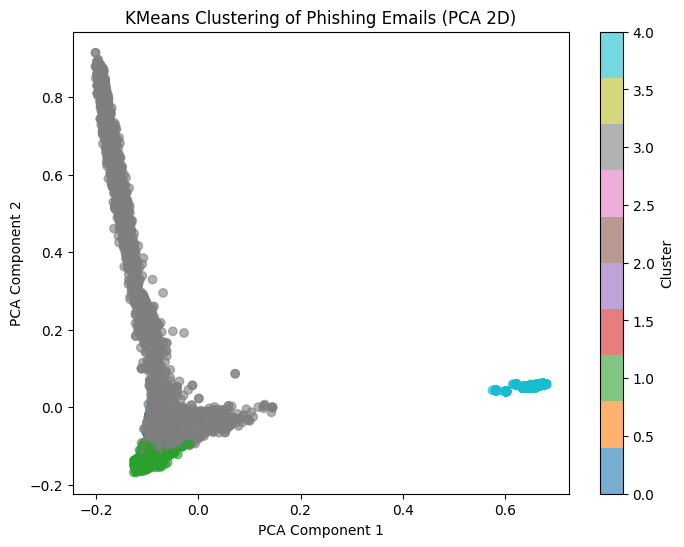

In [47]:
# --- Use only phishing emails for clustering ---
texts_to_cluster = df_emails[df_emails['label']==1]['clean_body']

# --- TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(texts_to_cluster)

# --- KMeans Clustering ---
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# --- PCA for visualization ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())  # This defines X_pca

# --- Scatter plot ---
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.title("KMeans Clustering of Phishing Emails (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

In [48]:
# --- Filter phishing emails ---
texts_to_cluster = df_emails[df_emails['label']==1]['clean_body']

# --- Vectorize with TF-IDF ---
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(texts_to_cluster)

# --- KMeans Clustering ---
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# --- Inspect top words per cluster ---
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i} top words: {top_words}\n")

# --- Optional: sample emails per cluster ---
df_clustered = df_emails[df_emails['label']==1].copy()
df_clustered['cluster'] = labels

for i in range(num_clusters):
    print(f"--- Sample emails from Cluster {i} ---")
    display(df_clustered[df_clustered['cluster']==i]['clean_body'].head(3))


Cluster 0 top words: ['cnn', 'suspect', 'news', 'montauk', 'beheading', 'pleads', 'monster', 'police', 'return', 'anthrax']

Cluster 1 top words: ['replica', 'watches', 'com', 'http', 'account', 'money', 'click', 'email', 'just', 'free']

Cluster 2 top words: ['cnn', 'alert', 'news', 'custom', 'settings', 'cable', 'network', 'com', 'alerts', 'email']

--- Sample emails from Cluster 0 ---


,clean_body
2861,the daily top from cnn com top videos and stor...
2866,the daily top from cnn com top videos and stor...
2868,the daily top from cnn com top videos and stor...


--- Sample emails from Cluster 1 ---


,clean_body
21,this is a multi part message in mime format ne...
38,note we do not wish to send e mail to anyone t...
84,just released email addresses plus bonuses inc...


--- Sample emails from Cluster 2 ---


,clean_body
14608,the daily top from cnn com top videos and stor...
14612,the daily top from cnn com top videos and stor...
14626,the daily top from cnn com top videos and stor...


###From TF-IDF analysis, we suspect that the first cluster of words seems to be phishing emails disguised as news alerts containing news outlets and sensational headlines including words like beheading, monster, anthrax. The second cluster seems to be phishing emails promoting commerical products labeled as free with actionable verbs like click and account.

In [49]:
# --- Sample phishing emails (optional, limits runtime) ---
sample_size = 500
texts_to_cluster = df_emails[df_emails['label']==1]['clean_body'].sample(n=min(sample_size, len(df_emails[df_emails['label']==1])), random_state=42)

# --- Vectorize for LDA ---
count_vectorizer = CountVectorizer(max_features=2000, stop_words='english')
X_counts = count_vectorizer.fit_transform(texts_to_cluster)

# --- Fit LDA ---
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_counts)

# --- Function to display top words per topic ---
def display_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {idx+1}: {top_features}")

# --- Display topics ---
display_topics(lda, count_vectorizer.get_feature_names_out(), 10)

Topic 1: ['cnn', 'com', 'news', 'network', 'cable', 'settings', 'alert', 'email', 'custom', 'videos']
Topic 2: ['pills', 'viagra', 'ge', 'po', 'mg', 'lar', 'ren', 'en', 've', 'mb']
Topic 3: ['company', 'click', 'information', 'new', 'free', 'com', 'statements', 'size', 'cfont', 'ffont']
Topic 4: ['money', 'bank', 'company', 'business', 'account', 'transaction', 'mr', 'million', 'foreign', 'email']
Topic 5: ['cnn', 'love', 'com', 'news', 'sex', 'women', 'daily', 'cable', 'hilton', 'paris']


###From LDA (Latent Dirichlet Allocation), we uncover similar phishing schemes. Additionally, we see pharmaceutical scams selling viagra pills and finanical fraud mentioning accounts and transactions.

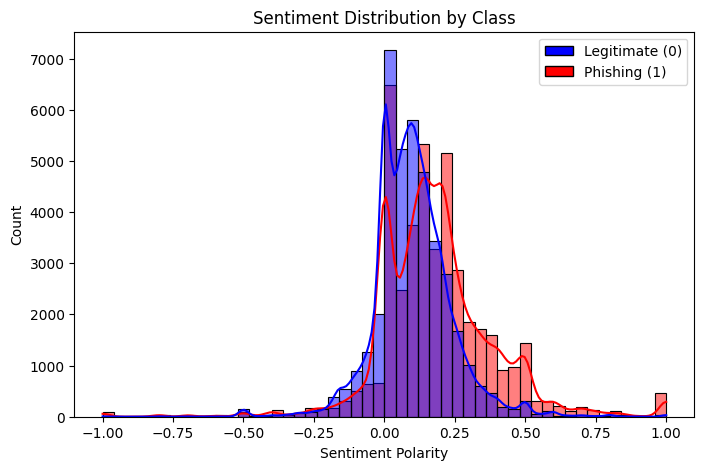

In [59]:
# --- Calculate sentiment polarity for each email ---
# Uses TextBlob to get polarity score: -1 (negative) to 1 (positive)
df_emails['sentiment'] = df_emails['clean_body'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8,5))

sns.histplot(
    data=df_emails,
    x='sentiment',
    hue='label',
    bins=50,
    kde=True,
    palette={0: 'blue', 1: 'red'},
    legend=False
)

plt.title("Sentiment Distribution by Class")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Count")

legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label='Legitimate (0)'),
    Patch(facecolor='red', edgecolor='black', label='Phishing (1)')
]
plt.legend(handles=legend_elements)

plt.show()


###By calculating sentiment polarity, we see that phishing emails generally have a more positive sentiment compared to legitimate emails, which means that sentiment analysis could be a helpful signal in detecting phishing.

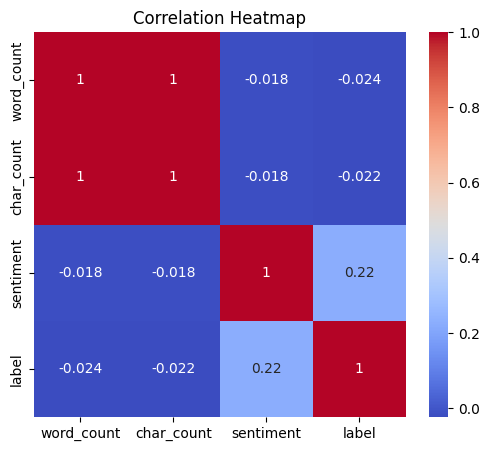

In [62]:
# --- Select numerical features and label for correlation analysis ---
# 'word_count' : number of words in email
# 'char_count' : number of characters in email
# 'sentiment'  : polarity score from TextBlob (-1 to 1)
# 'label'      : 0=legitimate, 1=phishing
df_features = df_emails[['word_count','char_count','sentiment','label']]

# --- Create a heatmap to visualize correlations ---
plt.figure(figsize=(6,5))

sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm')

plt.title("Correlation Heatmap")

# Display the heatmap
plt.show()


###This heatmap indicates that there is a positive correlation with sentiment and labels. There is also a negative correlation with word_count and label & char_count and label. This means that sentiment can be a good predictive feature for phishing detection whereas word_count and char_count are not.